In [1]:
!pip install filterpy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110541 sha256=6f9c22f97568a2c6bc483fdc336a67bed68bff3ef1c301e1e008af2ae983624c
  Stored in directory: c:\users\tarek\appdata\local\pip\cache\wheels\77\bf\4c\b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


In [3]:
# filter py: https://github.com/rlabbe/filterpy

In [5]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [3]:
import os
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from skimage import io

In [5]:
import glob
import time 
import argparse
from filterpy.kalman import KalmanFilter

In [7]:
# defining seed
np.random.seed(0)

### Kalman Filtering

In [9]:
# function  to convert bounding box to z 
def convert_bbox_to_z(bbox):
    """
      Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
    """
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h # scale is the area of the box 
    r = w / float(h)
    return np.array([x,y,s,r]).reshape((4,1))
    

In [11]:
# function to convert z to bbox
def convert_x_to_bbox(x, score=None):
    """
    This function takes a bounding box in the center form [x,y,s,r] and
    return it in the [x1,y1,x2,y2] where x1,y1 is the top left and 
    x2,y2 is the bottom right 
    """
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if(score==None):
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
    else:
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))
    

In [13]:
# Kalman Box tracker to predict the state of objects using Kalman Filter
class KalmanBoxTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as bbox.
    """
    count = 0
    def __init__(self, bbox):
        """
        Initializes a tracker using initial bounding box.
        """
        # define constant velocity model 
        self.kf = KalmanFilter(dim_x= 7, dim_z= 4)
        self.kf.F = np.array([[1,0,0,0,1,0,0],
                              [0,1,0,0,0,1,0],
                              [0,0,1,0,0,0,1],
                              [0,0,0,1,0,0,0],  
                              [0,0,0,0,1,0,0],
                              [0,0,0,0,0,1,0],
                              [0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],
                              [0,1,0,0,0,0,0],
                              [0,0,1,0,0,0,0],
                              [0,0,0,1,0,0,0]])
        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000.
        self.kf.P *= 0.01
        self.kf.Q[-1, -1] *= 0.01
        self.kf.Q[4:, 4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0
        
    def update(self, bbox):
        """
        Update the state vactor with observed box 
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(convert_bbox_to_z(bbox))

    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate
        """
        if((self.kf.x[6] + self.kf.x[2])<=0):
            self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1

        if(self.time_since_update>0):
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate 
        """
        return convert_x_to_bbox(self.kf.x)
      

In [15]:
# Test Case 1: Initialize and predict
bbox = np.array([50, 50, 150, 150])  # Example bounding box [x1, y1, x2, y2]

# Initialize tracker
tracker = KalmanBoxTracker(bbox)

# Print initial state
print("Initial bounding box (converted to state vector):")
print(tracker.get_state())

# Predict without updates
print("\nPredicted bounding box after 1 step:")
print(tracker.predict())

print("\nPredicted bounding box after 2 steps:")
print(tracker.predict())


Initial bounding box (converted to state vector):
[[ 50.  50. 150. 150.]]

Predicted bounding box after 1 step:
[[ 50.  50. 150. 150.]]

Predicted bounding box after 2 steps:
[[ 50.  50. 150. 150.]]


In [17]:
# New detection slightly shifted
new_bbox = np.array([55, 55, 155, 155])

# Update tracker with the new observation
tracker.update(new_bbox)

# Print updated state
print("\nUpdated bounding box after observation:")
print(tracker.get_state())



Updated bounding box after observation:
[[ 54.88377499  54.88377499 154.88377499 154.88377499]]


In [19]:
print("\nPredicted bounding box after 2 steps:")
print(tracker.predict())


Predicted bounding box after 2 steps:
[[ 57.20943747  57.20943747 157.20943747 157.20943747]]


In [21]:
from ultralytics import YOLO

In [23]:
# load YOLO-V8 model 
yolo_8 = YOLO("yolov8n.pt")

In [25]:
cycle_path = "../single_cv/videos/byc.mp4"
video2_path = '../single_cv/videos/walk_cycle.mp4'
video3_path = '../single_cv/videos/walk_dog.mp4'
video4_path = "../single_cv/videos/football.mp4"
video5_path = "../single_cv/videos/demo.mp4"
video6_path = "../single_cv/videos/byc.mp4"

In [27]:
import cv2

video = cv2.VideoCapture(video4_path)
height = 400
width = 600

while True:
    # get the current frame
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check you video!!")
        break
    # resized the frame with expected size 
    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)
    
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "sports ball":
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Get coordinates (x1, y1, x2, y2)
                
                # Draw bounding box on the frame
                color = (0, 255, 0)  # Green color for boxes (you can change this)
                cv2.rectangle(resized_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    
                # Put the label (class name) and confidence score on the frame
                text = f"{label} {conf:.2f}"
                cv2.putText(resized_frame, text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # showing the video
    cv2.imshow('video', resized_frame)
    
    key = cv2.waitKey(1)
    # press Esc to break 
    if key == 27:
        break
    pass

video.release()
cv2.destroyAllWindows()


0: 448x640 6 persons, 1 sports ball, 91.0ms
Speed: 5.0ms preprocess, 91.0ms inference, 11.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 54.0ms
Speed: 13.0ms preprocess, 54.0ms inference, 6.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 71.0ms
Speed: 17.0ms preprocess, 71.0ms inference, 11.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 71.0ms
Speed: 15.0ms preprocess, 71.0ms inference, 11.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 72.0ms
Speed: 19.0ms preprocess, 72.0ms inference, 11.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 sports ball, 76.0ms
Speed: 18.0ms preprocess, 76.0ms inference, 11.0ms postprocess per image at shape (1, 3, 448, 6

#### Visualizing effect of Kalman filter

In [29]:
# Load video and YOLO model
"""
Here, we are trying to apply Kalman Filter Method and visualize the output
The goal is how this filtering works 
This approach does not connect current frame with previous frame, it predicts for each frame
"""
video = cv2.VideoCapture(video4_path)
height, width = 400, 600
kalman_trackers = []  # List to store Kalman trackers for objects

while True:
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break

    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)  # YOLO model predictions

    # Iterate through each prediction
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "sports ball":  # Apply filter to specific class
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates

                # Draw detected bounding box (green)
                color = (0, 255, 0)  # Green color for boxes
                cv2.rectangle(resized_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

                # Initialize Kalman tracker for new object
                tracker_initialized = False
                for tracker in kalman_trackers:
                    # Update existing trackers if the predicted box overlaps (you can add your custom matching logic here)
                    pass

                if not tracker_initialized:
                    # Add new tracker for this object
                    tracker = KalmanBoxTracker([x1, y1, x2, y2])
                    kalman_trackers.append(tracker)

    # Update and predict for all trackers
    for tracker in kalman_trackers:
        # Predict the next position of tracked objects
        predicted_bbox = tracker.predict()

        # Draw the predicted bounding box (red)
        predicted_x1, predicted_y1, predicted_x2, predicted_y2 = predicted_bbox[0]
        predicted_color = (0, 0, 255)  # Red for predicted bounding box
        cv2.rectangle(resized_frame, (int(predicted_x1), int(predicted_y1)),
                      (int(predicted_x2), int(predicted_y2)), predicted_color, 2)

    # Show the video with bounding boxes
    cv2.imshow('video', resized_frame)

    key = cv2.waitKey(1)
    if key == 27:  # Press Esc to exit
        break

video.release()
cv2.destroyAllWindows()



0: 448x640 6 persons, 1 sports ball, 44.0ms
Speed: 3.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 62.0ms
Speed: 7.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 sports ball, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 44

In [33]:
import cv2
import numpy as np

"""
Output of this code does not separate points for each objects, rather it connects all the points
which is redundant and error
"""

video = cv2.VideoCapture(video5_path)
height, width = 400, 600
kalman_trackers = []  # List to store Kalman trackers for objects

# List to store previous positions for drawing the trajectory
previous_positions = []

while True:
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break

    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)  # YOLO model predictions

    # Iterate through each prediction
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "person":  # Apply filter to specific class
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates

                # Draw detected bounding box (green) for YOLO detection
                color = (0, 255, 0)  # Green color for boxes
                cv2.rectangle(resized_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

                # Initialize Kalman tracker for new object
                tracker_initialized = False
                for tracker in kalman_trackers:
                    # Update existing trackers if the predicted box overlaps (using IoU or distance)
                    # Here you can add the logic for checking overlap (IoU or distance-based)
                    # For now, we assume the object is new and needs a new tracker.
                    pass

                if not tracker_initialized:
                    # Add new tracker for this object (initialize with bounding box)
                    tracker = KalmanBoxTracker([x1, y1, x2, y2])
                    kalman_trackers.append(tracker)

    # Update and predict for all trackers
    for tracker in kalman_trackers:
        # Predict the next position of tracked objects
        predicted_bbox = tracker.predict()

        # Extract the predicted center position
        predicted_x1, predicted_y1, predicted_x2, predicted_y2 = predicted_bbox[0]
        predicted_center = np.array([(predicted_x1 + predicted_x2) / 2, (predicted_y1 + predicted_y2) / 2])

        # Draw the predicted center as a red dot
        predicted_color = (0, 0, 255)  # Red for predicted center
        cv2.circle(resized_frame, (int(predicted_center[0]), int(predicted_center[1])), 5, predicted_color, -1)

        # Draw the trajectory (blue line) for the tracked object
        if len(previous_positions) > 0:
            cv2.polylines(resized_frame, [np.array(previous_positions, dtype=np.int32)], isClosed=False, color=(255, 0, 0), thickness=2)

        # Add current position to trajectory
        previous_positions.append(predicted_center)

        # Limit the number of points in the trajectory to prevent overgrowth
        if len(previous_positions) > 20:  # Adjust this to your preference
            previous_positions.pop(0)

    # Show the video with bounding boxes and tracker
    cv2.imshow('video', resized_frame)

    key = cv2.waitKey(1)
    if key == 27:  # Press Esc to exit
        break

video.release()
cv2.destroyAllWindows()



0: 448x640 1 person, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 47.0ms
Speed: 2.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 44

In [53]:
def iou(box1, box2):
    """Calculate IoU (Intersection over Union) between two boxes"""
    x1, y1, x2, y2 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Compute intersection
    inter_x1 = max(x1, x1_2)
    inter_y1 = max(y1, y1_2)
    inter_x2 = min(x2, x2_2)
    inter_y2 = min(y2, y2_2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Compute areas of the boxes
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)

    # Compute IoU
    iou_value = inter_area / (area1 + area2 - inter_area)
    return iou_value


"""
Here, we have added IoU score comparision to get tracked an object through contineous frames 
If the object has a higher IoU score than its consecutive next frames then it has been considered
as the same tracker. Meaning, we are trying to building up a relationship between frames to avoid 
redundant and multiple tracking for a specific object throughout the frames. 

However, the output still connects the points of same time objects and also the trajectory fades out 
in consecutive frames. But it seems the consecutive frame matching based on IoU is working. It is also 
obsereved that for a single object it does well but the problem arises for multiple object
"""

video = cv2.VideoCapture(video3_path)
height, width = 400, 600
kalman_trackers = []  # Initialize Kalman trackers list

# Initialize list for storing the center positions of each object
object_centers = []

while True:
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break

    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)  # YOLO model predictions

    # Iterate through each prediction
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "person":  # Apply filter to specific class
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates

                # Draw detected bounding box (green) for YOLO detection
                color = (0, 255, 0)  # Green color for boxes
                cv2.rectangle(resized_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

                # Initialize Kalman tracker for new object if no match is found
                tracker_initialized = False
                for tracker in kalman_trackers:
                    predicted_bbox = tracker.predict()  # Get predicted bounding box
                    iou_value = iou(predicted_bbox[0], [x1, y1, x2, y2])  # Compare IoU

                    if iou_value > 0.5:  # You can adjust the threshold (0.5 here)
                        tracker.update([x1, y1, x2, y2])  # Update tracker with new bounding box
                        tracker_initialized = True
                        break  # If a match is found, no need to check further trackers

                # If no tracker is initialized for this object, add a new one
                if not tracker_initialized:
                    tracker = KalmanBoxTracker([x1, y1, x2, y2])  # Initialize new tracker
                    kalman_trackers.append(tracker)

    # Update and predict for all trackers
    for tracker in kalman_trackers:
        # Predict the next position of tracked objects
        predicted_bbox = tracker.predict()

        # Predict the next position of tracked objects
        predicted_bbox = tracker.predict()

        # Extract the predicted center position
        predicted_x1, predicted_y1, predicted_x2, predicted_y2 = predicted_bbox[0]
        predicted_center = np.array([(predicted_x1 + predicted_x2) / 2, (predicted_y1 + predicted_y2) / 2])

        # Draw the predicted center as a red dot
        predicted_color = (0, 0, 255)  # Red for predicted center
        cv2.circle(resized_frame, (int(predicted_center[0]), int(predicted_center[1])), 5, predicted_color, -1)

        # Draw the trajectory (blue line) for the tracked object
        if len(previous_positions) > 0:
            cv2.polylines(resized_frame, [np.array(previous_positions, dtype=np.int32)], isClosed=False, color=(255, 0, 0), thickness=2)

        # Add current position to trajectory
        previous_positions.append(predicted_center)

        # Limit the number of points in the trajectory to prevent overgrowth
        if len(previous_positions) > 20:  # Adjust this to your preference
            previous_positions.pop(0)

    # Show the video with bounding boxes and tracker
    cv2.imshow('video', resized_frame)

    key = cv2.waitKey(1)
    if key == 27:  # Press Esc to exit
        break

video.release()
cv2.destroyAllWindows()



0: 448x640 (no detections), 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 47.0ms
Speed: 2.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms i

In [75]:
# THIS ONE GIVES THE PERFECT TRACKING 

"""
This approach solved the problem of connecting points of different objects or same type multiple objects
Tracker can changed after few frames, it goes with the same point for a specific tracker
When the tracker changes, new point created and the old ones faded out like an animation!
Observation: 
    Tracker usually change for fast moving objects or when the position of objects change suddenly 
    into different representation. For example, a person is excersising, the tracker remain same. But 
    the person jumps, this event can take place within seconds, and his/her body representation may changes 
    dramatically. So, based on the IoU threshold the tracker can be lost. 
"""

video = cv2.VideoCapture(video5_path)
height, width = 400, 600
kalman_trackers = []  # Initialize Kalman trackers list

# Initialize list for storing the center positions of each object
object_centers = {}  # Now store per tracker, not globally
max_trajectory_length = 20  # Limit trajectory to the last 20 frames

while True:
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break

    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)  # YOLO model predictions

    # Iterate through each prediction
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "person":  # Apply filter to specific class
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates

                # Draw detected bounding box (green) for YOLO detection
                color = (0, 255, 0)  # Green color for boxes
                cv2.rectangle(resized_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

                # Initialize Kalman tracker for new object if no match is found
                tracker_initialized = False
                for tracker in kalman_trackers:
                    predicted_bbox = tracker.predict()  # Get predicted bounding box
                    iou_value = iou(predicted_bbox[0], [x1, y1, x2, y2])  # Compare IoU

                    if iou_value > 0.5:  # You can adjust the threshold (0.5 here)
                        tracker.update([x1, y1, x2, y2])  # Update tracker with new bounding box
                        tracker_initialized = True
                        break  # If a match is found, no need to check further trackers

                # If no tracker is initialized for this object, add a new one
                if not tracker_initialized:
                    tracker = KalmanBoxTracker([x1, y1, x2, y2])  # Initialize new tracker
                    kalman_trackers.append(tracker)

    # Update and predict for all trackers
    for tracker in kalman_trackers:
        # Predict the next position of tracked objects
        predicted_bbox = tracker.predict()

        # Extract the predicted center position
        predicted_x1, predicted_y1, predicted_x2, predicted_y2 = predicted_bbox[0]
        predicted_center = np.array([(predicted_x1 + predicted_x2) / 2, (predicted_y1 + predicted_y2) / 2])

        # Draw the predicted center as a red dot
        predicted_color = (0, 0, 255)  # Red for predicted center
        cv2.circle(resized_frame, (int(predicted_center[0]), int(predicted_center[1])), 5, predicted_color, -1)

        # Track and draw the trajectory for each tracker individually
        if tracker not in object_centers:
            print(f"The tracker: {tracker}")
            object_centers[tracker] = []

        # Add current position to trajectory
        object_centers[tracker].append(predicted_center)

        # Limit the number of points in the trajectory to prevent overgrowth
        if len(object_centers[tracker]) > max_trajectory_length:
            object_centers[tracker].pop(0)

        # Draw the trajectory (blue line) for the tracked object
        for i in range(1, len(object_centers[tracker])):
            cv2.line(resized_frame, (int(object_centers[tracker][i-1][0]), int(object_centers[tracker][i-1][1])),
                     (int(object_centers[tracker][i][0]), int(object_centers[tracker][i][1])), (255, 0, 0), 2)

    # Show the video with bounding boxes and tracker
    cv2.imshow('video', resized_frame)

    key = cv2.waitKey(1)
    if key == 27:  # Press Esc to exit
        break

video.release()
cv2.destroyAllWindows()



0: 448x640 1 person, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
The tracker: <__main__.KalmanBoxTracker object at 0x00000250CC98A060>

0: 448x640 1 person, 62.0ms
Speed: 28.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 36.0ms
Speed: 1.0ms prepr

In [83]:
"""
Here, the output result is similar to the previous approach.
We tried to get rid of those faded away points by storing lost frame,
but eventually it did not work out as we expected!!
"""

video = cv2.VideoCapture(video4_path)
height, width = 400, 600
kalman_trackers = []  # Initialize Kalman trackers list

# Max number of frames an object can be lost before we stop tracking or reset trajectory
max_lost_frames = 5

# Track the number of frames each tracker has been lost
tracker_lost_frames = {}

while True:
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break

    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)  # YOLO model predictions

    # Iterate through each prediction
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "person":  # Apply filter to specific class
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Bounding box coordinates

                # Draw detected bounding box (green) for YOLO detection
                color = (0, 255, 0)  # Green color for boxes
                cv2.rectangle(resized_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

                # Initialize Kalman tracker for new object if no match is found
                tracker_initialized = False
                for tracker in kalman_trackers:
                    predicted_bbox = tracker.predict()  # Get predicted bounding box
                    iou_value = iou(predicted_bbox[0], [x1, y1, x2, y2])  # Compare IoU

                    if iou_value > 0.5:  # You can adjust the threshold (0.5 here)
                        tracker.update([x1, y1, x2, y2])  # Update tracker with new bounding box
                        tracker_initialized = True
                        tracker_lost_frames[tracker] = 0  # Reset the lost frame counter
                        break  # If a match is found, no need to check further trackers

                # If no tracker is initialized for this object, add a new one
                if not tracker_initialized:
                    tracker = KalmanBoxTracker([x1, y1, x2, y2])  # Initialize new tracker
                    kalman_trackers.append(tracker)
                    tracker_lost_frames[tracker] = 0  # Start counting lost frames

    # Update and predict for all trackers
    for tracker in kalman_trackers:
        # Predict the next position of tracked objects
        predicted_bbox = tracker.predict()

        # Extract the predicted center position
        predicted_x1, predicted_y1, predicted_x2, predicted_y2 = predicted_bbox[0]
        predicted_center = np.array([(predicted_x1 + predicted_x2) / 2, (predicted_y1 + predicted_y2) / 2])

        # If the tracker is lost for too many frames, stop drawing its trajectory
        if tracker in tracker_lost_frames and tracker_lost_frames[tracker] > max_lost_frames:
            continue  # Don't update the trajectory for lost objects

        # Draw the predicted center as a red dot
        predicted_color = (0, 0, 255)  # Red for predicted center
        cv2.circle(resized_frame, (int(predicted_center[0]), int(predicted_center[1])), 5, predicted_color, -1)

        # Track and draw the trajectory for each tracker individually
        if tracker not in object_centers:
            object_centers[tracker] = []

        # Add current position to trajectory
        object_centers[tracker].append(predicted_center)

        # Limit the number of points in the trajectory to prevent overgrowth
        if len(object_centers[tracker]) > max_trajectory_length:
            object_centers[tracker].pop(0)

        # Draw the trajectory (blue line) for the tracked object
        for i in range(1, len(object_centers[tracker])):
            cv2.line(resized_frame, (int(object_centers[tracker][i-1][0]), int(object_centers[tracker][i-1][1])),
                     (int(object_centers[tracker][i][0]), int(object_centers[tracker][i][1])), (255, 0, 0), 2)

    # Show the video with bounding boxes and tracker
    cv2.imshow('video', resized_frame)

    key = cv2.waitKey(1)
    if key == 27:  # Press Esc to exit
        break

video.release()
cv2.destroyAllWindows()



0: 448x640 6 persons, 1 sports ball, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 sports ball, 40.0ms
Speed: 1.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 sports ball, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 44

### Implement the SORT with Kalman filter and Hungarian method
We have seen earlier that Kalman filter provides good estimation over the frames. But in our case, tracking using Kalman filter only has some limitation, therefore, we must need association. We will achieve the perfect tracking with association by combining the Hungarian algorithm and Kalman filtering.

In [29]:
def iou_batch(bb_test, bb_gt):
  """
  From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
  """
  bb_gt = np.expand_dims(bb_gt, 0)
  bb_test = np.expand_dims(bb_test, 1)
  
  xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
  yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
  xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
  yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
  w = np.maximum(0., xx2 - xx1)
  h = np.maximum(0., yy2 - yy1)
  wh = w * h
  o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])                                      
    + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)                                              
  return(o)  


In [109]:
!pip install lap

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 279.8 kB/s eta 0:00:04
   -------------- ------------------------- 0.5/1.5 MB 279.8 kB/s eta 0:00:04
   -------------- ------------------------- 0.5/1.5 MB 279.8 kB/s eta 0:00:04
   -------------- ------------------------- 0.5/1.5 MB 279.8 kB/s eta 0:00:0

In [31]:
"""
lap-> linear assignement problem solver 
this package utilize to solve the assignment problem using hungarian method \
which is also called Munkres algorithm
This package mostly utilized in multi-object tracking, cost minimization and 
matching problems 
"""
# sample usage of this package 

import lap

# Example cost matrix (3 workers, 3 tasks)
cost_matrix = np.array([[4, 2, 8], 
                        [6, 7, 3], 
                        [5, 4, 6]])

# Solve the linear assignment problem
cost, row_ind, col_ind = lap.lapjv(cost_matrix)

# Display results
print(f"Minimum cost: {cost}")
print("Assigned rows:", row_ind)  # Each worker is assigned to a task
print("Assigned columns:", col_ind)  # Tasks assigned optimally

# Interpretation 
print(f"Worker 1 --> Task {cost_matrix[0][row_ind[0]]}")
print(f"Worker 2 --> Task {cost_matrix[1][row_ind[1]]}")
print(f"Worker 3 --> Task {cost_matrix[2][row_ind[2]]}")
total_cost = cost_matrix[0][row_ind[0]] + cost_matrix[1][row_ind[1]] + cost_matrix[2][row_ind[2]]
print(f"Total cost after applying lap: {total_cost}")

Minimum cost: 10.0
Assigned rows: [1 2 0]
Assigned columns: [2 0 1]
Worker 1 --> Task 2
Worker 2 --> Task 3
Worker 3 --> Task 5
Total cost after applying lap: 10


In [31]:
N=3
M=3
x = row_ind
A = np.zeros((N, M))
for i in range(N):
    A[i, x[i]] = 1

In [33]:
print(f"The assigned task can be represented as: \n{A}")

The assigned task can be represented as: 
[[          0           1           0]
 [          0           0           1]
 [          1           0           0]]


In [33]:
# FUNCTION FOR LINEAR ASSIGNMENT
def linear_assignment(cost_matrix):
    try:
        import lap
        _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        return np.array([[y[i],i] for i in x if i >= 0])
    except ImportError:
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x,y)))
        

In [37]:
_, x, y = lap.lapjv(cost_matrix, extend_cost=True)
mapped_worker_to_task = np.array([[y[i],i] for i in x if i >= 0])
mapped_worker_to_task

array([[0, 1],
       [1, 2],
       [2, 0]])

In [35]:
def associate_detection_to_trackers(detections, trackers, iou_threshold= 0.3):
    """
    Assigns detections to tracked object (both represented as bounding boxes)
    Resturns 3 lists of mathches, unmatched_detections and unmatched_trackers
    """
    if(len(trackers)==0):
        return np.empty((0,2), dtype=int), np.arange(len(detections)), np.empty((0,5), dtype=int)
    # gettig the iou scores 
    iou_matrix = iou_batch(detections, trackers)

    if min(iou_matrix.shape) > 0:
        a = (iou_matrix > iou_threshold).astype(np.int32)
        if a.sum(1).max() == 1 and a.sum(0).max() == 1:
            matched_indices = np.stack(np.where(a), axis=1)
        else:
            matched_indices = linear_assignment(-iou_matrix)
    else:
        matched_indices = np.empty(shape=(0,2))

    unmatched_detections = []
    for d, det in enumerate(detections):
        if(d not in matched_indices[:,0]):
            unmatched_detections.append(d)
    unmatched_trackers = []
    for t, trk in enumerate(trackers):
        if(t not in matched_indices[:1]):
            unmatched_trackers.append(t)

    # filter out matched with low IoU
    matches = []
    for m in matched_indices:
        if(iou_matrix[m[0], m[1]] < iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    if(len(matches)==0):
        matches = np.empty((0,2), dtype=int)
    else:
        matches = np.concatenate(matches, axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)
    

In [105]:
k = np.arange(5)
min(k.shape)

5

In [37]:
# SORT ALGORITHM
class Sort(object):
    def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3):
        """
        Sets key parameters for SORT
        max_age: how many frames a tracker can survive without a match
        min_hits:  how many consecutive frames a new object must be 
        detected before it is confirmed as a valid track
        iou_threshold: minimum Intersection over Union (IoU) score required 
        to associate a detection with an existing tracker.
        """
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.trackers = []
        self.frame_count = 0

    def update(self, dets=np.empty((0,5))):
        """
        Params:
        dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
        Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
        Returns the a similar array, where the last column is the object ID.

        NOTE: The number of objects returned may differ from the number of detections provided.
        """
        self.frame_count += 1
        # get predicted locations from existing tracker 
        trks = np.zeros((len(self.trackers), 5))
        to_del = []
        ret = []
        for t, trk in enumerate(trks):
            pos = self.trackers[t].predict()[0]
            trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
            if np.any(np.isnan(pos)):
                to_del.append(t)
        trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
        for t in reversed(to_del):
            self.trackers.pop(t)
        matched, unmathced_dets, unmatched_trks = associate_detection_to_trackers(dets, trks, self.iou_threshold)

        # update matched trackers with assigned detections
        for m in matched:
            self.trackers[m[1]].update(dets[m[0], :])

        # create and initialise new trackers for unmatched detections 
        for i in unmathced_dets:
            trk = KalmanBoxTracker(dets[i,:])
            self.trackers.append(trk)
        i = len(self.trackers)
        for trk in reversed(self.trackers):
            d = trk.get_state()[0]
            if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
                ret.append(np.concatenate((d, [trk.id+1])).reshape(1,-1)) # # +1 as MOT benchmark requires positive
            i -= 1
            # remove dead tracklet 
            if(trk.time_since_update > self.max_age):
                self.trackers.pop(i)

        if(len(ret)>0):
            return np.concatenate(ret)

        return np.empty((0,5))

In [39]:
# define tracker algorithm 
mot_tracker = Sort(max_age=5, 
                       min_hits=5,
                       iou_threshold=0.6) #create instance of the SORT tracker

In [83]:
# 
video = cv2.VideoCapture(video3_path)
height = 400
width = 600

while True:
    # get the current frame
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check you video!!")
        break
    # resized the frame with expected size 
    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)

    detections = []
    
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "person":
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Get coordinates (x1, y1, x2, y2)
                detections.append([x1, y1, x2, y2, conf])  # Format for SORT
    
    # Convert detections to NumPy array
    detections = np.array(detections) if len(detections) > 0 else np.empty((0, 5))
    
    # get the tracked objects  
    tracked_objects = mot_tracker.update(detections)

    # draw tracking results 
    for trk_obj in tracked_objects:
        x1, y1, x2, y2, trk_id = trk_obj.astype(int)
        cv2.rectangle(resized_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(resized_frame, f"ID {trk_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # showing the video
    cv2.imshow('SORT', resized_frame)
    
    key = cv2.waitKey(1)
    # press Esc to break 
    if key == 27:
        break
    pass

video.release()
cv2.destroyAllWindows()


0: 448x640 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 46.0ms
Speed: 3.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 44.0ms
Speed: 2.0ms preprocess, 44.0ms i

In [85]:
# Keep a dictionary to store previous positions for each tracker ID
tracker_positions = {}

video = cv2.VideoCapture(video3_path)
height = 400
width = 600

while True:
    # get the current frame
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break
    # resized the frame with expected size 
    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)

    detections = []
    
    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "person":
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Get coordinates (x1, y1, x2, y2)
                detections.append([x1, y1, x2, y2, conf])  # Format for SORT
    
    # Convert detections to NumPy array
    detections = np.array(detections) if len(detections) > 0 else np.empty((0, 5))
    
    # get the tracked objects  
    tracked_objects = mot_tracker.update(detections)

    # draw tracking results 
    for trk_obj in tracked_objects:
        x1, y1, x2, y2, trk_id = trk_obj.astype(int)
        
        # Draw the bounding box
        cv2.rectangle(resized_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(resized_frame, f"ID {trk_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Get current position of the tracked object (center point of the bounding box)
        current_position = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Store previous positions for each object
        if trk_id not in tracker_positions:
            tracker_positions[trk_id] = []

        # Append current position to the list of positions for the current object
        tracker_positions[trk_id].append(current_position)

        # Draw a point (circle) at the current position
        cv2.circle(resized_frame, current_position, 5, (0, 0, 255), -1)  # Red point

        # Draw lines for the path of the object
        if len(tracker_positions[trk_id]) > 1:
            # If there are previous positions, draw lines connecting them
            for i in range(1, len(tracker_positions[trk_id])):
                cv2.line(resized_frame, tracker_positions[trk_id][i - 1], tracker_positions[trk_id][i], (255, 0, 0), 2)  # Blue line

    # showing the video
    cv2.imshow('SORT', resized_frame)
    
    key = cv2.waitKey(1)
    # press Esc to break 
    if key == 27:
        break
    pass

video.release()
cv2.destroyAllWindows()



0: 448x640 (no detections), 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 46.0ms
Speed: 3.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 141.0ms
Speed: 1.0ms preprocess, 141.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 42.0ms
Speed: 2.0ms preprocess, 42.0ms

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Keep a dictionary to store previous positions for each tracker ID
tracker_positions = {}

video = cv2.VideoCapture(video3_path)
height = 400
width = 600

frame_count = 0

while True:
    # get the current frame
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break

    # Resize the frame to the expected size
    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)

    detections = []

    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "person":
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Get coordinates (x1, y1, x2, y2)
                cls_name = label
                detections.append([x1, y1, x2, y2, conf])  # Format for SORT

    # Convert detections to NumPy array
    detections = np.array(detections) if len(detections) > 0 else np.empty((0, 5))

    # Get the tracked objects
    tracked_objects = mot_tracker.update(detections)

    # Draw tracking results
    for trk_obj in tracked_objects:
        x1, y1, x2, y2, trk_id = trk_obj.astype(int)

        # Draw the bounding box
        cv2.rectangle(resized_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(resized_frame, f"ID {trk_id}: {cls_name}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Get current position of the tracked object (center point of the bounding box)
        current_position = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Store previous positions for each object
        if trk_id not in tracker_positions:
            tracker_positions[trk_id] = {'positions': [], 'time': [], 'object': []}

        # Append current position to the list of positions for the current object
        tracker_positions[trk_id]['positions'].append(current_position)
        tracker_positions[trk_id]['time'].append(frame_count)
        tracker_positions[trk_id]['object'].append(cls_name)

        # Draw a red point (circle) at the current position
        cv2.circle(resized_frame, current_position, 5, (0, 0, 255), -1)  # Red point

        # Draw a blue line connecting previous positions to the current position
        if len(tracker_positions[trk_id]['positions']) > 1:
            for i in range(1, len(tracker_positions[trk_id]['positions'])):
                cv2.line(resized_frame, 
                         tracker_positions[trk_id]['positions'][i - 1], 
                         tracker_positions[trk_id]['positions'][i], 
                         (255, 0, 0), 2)  # Blue line

    # Show the video frame with bounding boxes and tracking lines
    cv2.imshow('SORT', resized_frame)

    key = cv2.waitKey(1)
    if key == 27:
        break

    frame_count += 1

video.release()
cv2.destroyAllWindows()



0: 448x640 (no detections), 46.0ms
Speed: 4.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 47.0ms
Speed: 2.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 48.0ms
Speed: 2.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 42.0ms
Speed: 2.0ms preprocess, 42.0ms i

In [171]:
# # Now, plot the movement graph in a new Jupyter cell

# # Create a plot
# fig, ax = plt.subplots()

# # Plot the trajectories
# for trk_id, data in tracker_positions.items():
#     x_vals = [pos[0] for pos in data['positions']]
#     y_vals = [pos[1] for pos in data['positions']]
#     obj_name = data['object']
#     print(f"Total frame captured in ID: {trk_id}: {len(obj_name)}")
#     ax.plot(data['time'], x_vals, label=f"{trk_id}: {obj_name[0]} X")  # X coordinate over time
#     ax.plot(data['time'], y_vals, label=f"{trk_id}: {obj_name[0]} Y")  # Y coordinate over time

# ax.set_title("Object Tracking Over Time")
# ax.set_xlabel("Frame Number")
# ax.set_ylabel("Position (Pixels)")
# ax.legend()

# plt.show()


In [173]:
# # Now, plot the movement graph as a trajectory in a new Jupyter cell

# # Create a plot
# fig, ax = plt.subplots()
# ax.set_title("Object Tracking Trajectories")
# ax.set_xlabel("X Position (Pixels)")
# ax.set_ylabel("Y Position (Pixels)")

# # Flip the Y-axis because in images, (0,0) is at the top-left
# ax.invert_yaxis()

# # Plot the trajectories
# for trk_id, data in tracker_positions.items():
#     x_vals = [pos[0] for pos in data['positions']]
#     y_vals = [pos[1] for pos in data['positions']]
    
#     obj_name = data['object']
#     print(f"Total frame captured in ID: {trk_id}: {len(obj_name)}")

#     ax.plot(x_vals, y_vals, marker='o', linestyle='-', label=f"{trk_id}: {obj_name[0]}")

# ax.legend()
# plt.show()


Total frame captured in ID: 2: 3
Total frame captured in ID: 3: 69
Total frame captured in ID: 4: 128
Total frame captured in ID: 10: 5
Total frame captured in ID: 13: 12
Total frame captured in ID: 17: 158
Total frame captured in ID: 20: 2


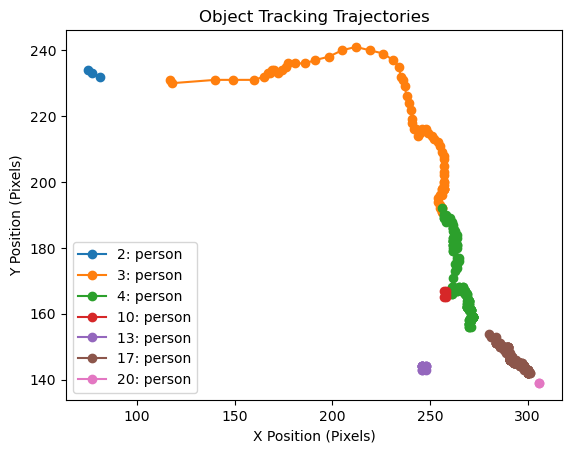

In [43]:
"""
The previous plot perfectly but it's mirror representation.
To make it similar to the video, we need to mirror the trajectory horizontally.
Therefore, we need to convert x into x', where x'=image_width - x
It will perfectly plot similar to input video plot
"""

# Create a plot
fig, ax = plt.subplots()
ax.set_title("Object Tracking Trajectories")
ax.set_xlabel("X Position (Pixels)")
ax.set_ylabel("Y Position (Pixels)")

# Get the frame width and height
image_width = 600   # Use the width of the processed video frames
image_height = 400 # Use the height of the processed video frames

# Plot the corrected trajectories
for trk_id, data in tracker_positions.items():
    x_vals = [image_width - pos[0] for pos in data['positions']]  # Flip X-coordinates
    y_vals = [image_height - pos[1] for pos in data['positions']] # Flip Y-coordinates
    
    obj_name = data['object']
    print(f"Total frame captured in ID: {trk_id}: {len(obj_name)}")

    ax.plot(x_vals, y_vals, marker='o', linestyle='-', label=f"{trk_id}: {obj_name[0]}")

ax.legend()
plt.show()


In [45]:
import cv2
# function to perform real-time tracking 
def get_track(file_path, desised_obj, height=600, width=800):
    # Keep a dictionary to store previous positions for each tracker ID
    tracker_positions = {}
    
    video = cv2.VideoCapture(file_path)
    # height = 600
    # width = 800
    
    frame_count = 0
    
    while True:
        # get the current frame
        check, frame = video.read()
        if not check:
            print(f"Failed to grab the frame, please check your video!")
            break
    
        # Resize the frame to the expected size
        resized_frame = cv2.resize(frame, (width, height))
        pred_results = yolo_8(resized_frame)
    
        detections = []
    
        for result in pred_results:
            boxes = result.boxes  # Bounding boxes
            for box in boxes:
                cls = box.cls[0].cpu().numpy()  # Class index
                label = result.names[int(cls)]  # Get class label
                if label == desised_obj:
                    conf = box.conf[0].cpu().numpy()  # Confidence score
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Get coordinates (x1, y1, x2, y2)
                    cls_name = label
                    detections.append([x1, y1, x2, y2, conf])  # Format for SORT
    
        # Convert detections to NumPy array
        detections = np.array(detections) if len(detections) > 0 else np.empty((0, 5))
    
        # Get the tracked objects
        tracked_objects = mot_tracker.update(detections)
    
        # Draw tracking results
        for trk_obj in tracked_objects:
            x1, y1, x2, y2, trk_id = trk_obj.astype(int)
    
            # Draw the bounding box
            cv2.rectangle(resized_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(resized_frame, f"ID {trk_id}: {cls_name}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
            # Get current position of the tracked object (center point of the bounding box)
            current_position = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    
            # Store previous positions for each object
            if trk_id not in tracker_positions:
                tracker_positions[trk_id] = {'positions': [], 'time': [], 'object': []}
    
            # Append current position to the list of positions for the current object
            tracker_positions[trk_id]['positions'].append(current_position)
            tracker_positions[trk_id]['time'].append(frame_count)
            tracker_positions[trk_id]['object'].append(cls_name)
    
            # Draw a red point (circle) at the current position
            cv2.circle(resized_frame, current_position, 5, (0, 0, 255), -1)  # Red point
    
            # Draw a blue line connecting previous positions to the current position
            if len(tracker_positions[trk_id]['positions']) > 1:
                for i in range(1, len(tracker_positions[trk_id]['positions'])):
                    cv2.line(resized_frame, 
                             tracker_positions[trk_id]['positions'][i - 1], 
                             tracker_positions[trk_id]['positions'][i], 
                             (255, 0, 0), 2)  # Blue line
    
        # Show the video frame with bounding boxes and tracking lines
        cv2.imshow('SORT', resized_frame)
    
        key = cv2.waitKey(1)
        if key == 27:
            break
    
        frame_count += 1
    
    video.release()
    cv2.destroyAllWindows()
    return tracker_positions


In [47]:
# function to print the trajectory of tracked objects 
def plot_tracking_trajectory(tr_maps, image_width=800, image_height=600):
    # Create a plot
    fig, ax = plt.subplots()
    ax.set_title("Object Tracking Trajectories")
    ax.set_xlabel("X Position (Pixels)")
    ax.set_ylabel("Y Position (Pixels)")
    
    # Get the frame width and height
    # image_width = 800   # Use the width of the processed video frames
    # image_height = 600 # Use the height of the processed video frames
    
    # Plot the corrected trajectories
    for trk_id, data in tr_maps.items():
        x_vals = [image_width - pos[0] for pos in data['positions']]  # Flip X-coordinates
        y_vals = [image_height - pos[1] for pos in data['positions']] # Flip Y-coordinates
        
        obj_name = data['object']
        print(f"Total frame captured in ID: {trk_id}: {len(obj_name)}")
    
        ax.plot(x_vals, y_vals, marker='o', linestyle='-', label=f"{trk_id}: {obj_name[0]}")
    
    ax.legend()
    plt.show()

In [51]:
# running videos 
boxing_path = "../r_videos/boxing_1.mp4"
car1_path = "../r_videos/car_1.mp4"
car2_path = "../r_videos/car_2.mp4"
car3_path = "../r_videos/car_3.mp4"
car4_path = "../r_videos/car_4.mp4"
horse_path = "../r_videos/horse_1.mp4"
run1_path = "../r_videos/run_1.mp4"
run2_path = "../r_videos/run_2.mp4"
run3_path = "../r_videos/run_3.mp4"
run4_path = "../r_videos/run_4.mp4"
run5_path = "../r_videos/run_5.mp4"
sports1_path = "../r_videos/sports_1.mp4"
sports2_path = "../r_videos/sports_2.mp4"

In [57]:
# tr_maps = get_track(boxing_path, 'person', height=500, width=700)
# tr_maps = get_track(car1_path, 'car', height=600, width=400)
# tr_maps = get_track(car2_path, 'car', height=400, width=600)
# tr_maps = get_track(car3_path, 'car', height=600, width=800)
tr_maps = get_track(car4_path, 'car', height=650, width=450)
# tr_maps = get_track(horse_path, 'horse', height=400, width=600)
# tr_maps = get_track(run1_path, 'person', height=400, width=600)
# tr_maps = get_track(run2_path, 'person', height=400, width=600)
# tr_maps = get_track(run3_path, 'person', height=400, width=600)
# tr_maps = get_track(run4_path, 'person', height=400, width=600)
# tr_maps = get_track(run5_path, 'dog', height=400, width=600)
# tr_maps = get_track(sports1_path, 'person', height=500, width=350)
# tr_maps = get_track(sports2_path, 'person', height=500, width=350)


0: 640x448 1 car, 124.0ms
Speed: 17.0ms preprocess, 124.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1

Total frame captured in ID: 22: 53
Total frame captured in ID: 24: 26
Total frame captured in ID: 27: 3


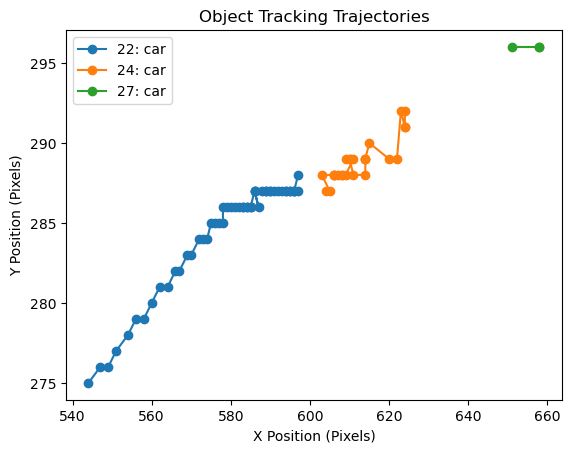

In [55]:
plot_tracking_trajectory(tr_maps)

#### Vehicle

In [40]:
road_path = "../single_cv/videos/input_day.mp4"

# Keep a dictionary to store previous positions for each tracker ID
tracker_positions = {}

video = cv2.VideoCapture(road_path)
height = 400
width = 600

frame_count = 0

while True:
    # get the current frame
    check, frame = video.read()
    if not check:
        print(f"Failed to grab the frame, please check your video!")
        break

    # Resize the frame to the expected size
    resized_frame = cv2.resize(frame, (width, height))
    pred_results = yolo_8(resized_frame)

    detections = []

    for result in pred_results:
        boxes = result.boxes  # Bounding boxes
        for box in boxes:
            cls = box.cls[0].cpu().numpy()  # Class index
            label = result.names[int(cls)]  # Get class label
            if label == "car":
                conf = box.conf[0].cpu().numpy()  # Confidence score
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Get coordinates (x1, y1, x2, y2)
                cls_name = label
                detections.append([x1, y1, x2, y2, conf])  # Format for SORT

    # Convert detections to NumPy array
    detections = np.array(detections) if len(detections) > 0 else np.empty((0, 5))

    # Get the tracked objects
    tracked_objects = mot_tracker.update(detections)

    # Draw tracking results
    for trk_obj in tracked_objects:
        x1, y1, x2, y2, trk_id = trk_obj.astype(int)

        # Draw the bounding box
        cv2.rectangle(resized_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(resized_frame, f"ID {trk_id}: {cls_name}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Get current position of the tracked object (center point of the bounding box)
        current_position = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Store previous positions for each object
        if trk_id not in tracker_positions:
            tracker_positions[trk_id] = {'positions': [], 'time': [], 'object': []}

        # Append current position to the list of positions for the current object
        tracker_positions[trk_id]['positions'].append(current_position)
        tracker_positions[trk_id]['time'].append(frame_count)
        tracker_positions[trk_id]['object'].append(cls_name)

        # Draw a red point (circle) at the current position
        cv2.circle(resized_frame, current_position, 5, (0, 0, 255), -1)  # Red point

        # Draw a blue line connecting previous positions to the current position
        if len(tracker_positions[trk_id]['positions']) > 1:
            for i in range(1, len(tracker_positions[trk_id]['positions'])):
                cv2.line(resized_frame, 
                         tracker_positions[trk_id]['positions'][i - 1], 
                         tracker_positions[trk_id]['positions'][i], 
                         (255, 0, 0), 2)  # Blue line

    # Show the video frame with bounding boxes and tracking lines
    cv2.imshow('SORT', resized_frame)

    key = cv2.waitKey(1)
    if key == 27:
        break

    frame_count += 1

video.release()
cv2.destroyAllWindows()


0: 448x640 19 cars, 1 bus, 3 trucks, 49.0ms
Speed: 3.0ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 20 cars, 1 bus, 3 trucks, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 19 cars, 1 bus, 2 trucks, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 20 cars, 1 bus, 2 trucks, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 19 cars, 1 bus, 2 trucks, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 20 cars, 1 bus, 3 trucks, 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 20 cars, 1 bus, 2 trucks, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 44

Total frame captured in ID: 39: 13
Total frame captured in ID: 38: 5
Total frame captured in ID: 37: 334
Total frame captured in ID: 36: 11
Total frame captured in ID: 35: 77
Total frame captured in ID: 34: 25
Total frame captured in ID: 33: 306
Total frame captured in ID: 32: 21
Total frame captured in ID: 31: 6
Total frame captured in ID: 30: 17
Total frame captured in ID: 29: 284
Total frame captured in ID: 28: 7
Total frame captured in ID: 27: 168
Total frame captured in ID: 26: 256
Total frame captured in ID: 25: 124
Total frame captured in ID: 24: 90
Total frame captured in ID: 23: 145
Total frame captured in ID: 22: 72
Total frame captured in ID: 46: 168
Total frame captured in ID: 45: 47
Total frame captured in ID: 43: 2
Total frame captured in ID: 48: 1
Total frame captured in ID: 50: 175
Total frame captured in ID: 55: 68
Total frame captured in ID: 57: 1
Total frame captured in ID: 58: 14
Total frame captured in ID: 63: 1
Total frame captured in ID: 71: 1
Total frame capture

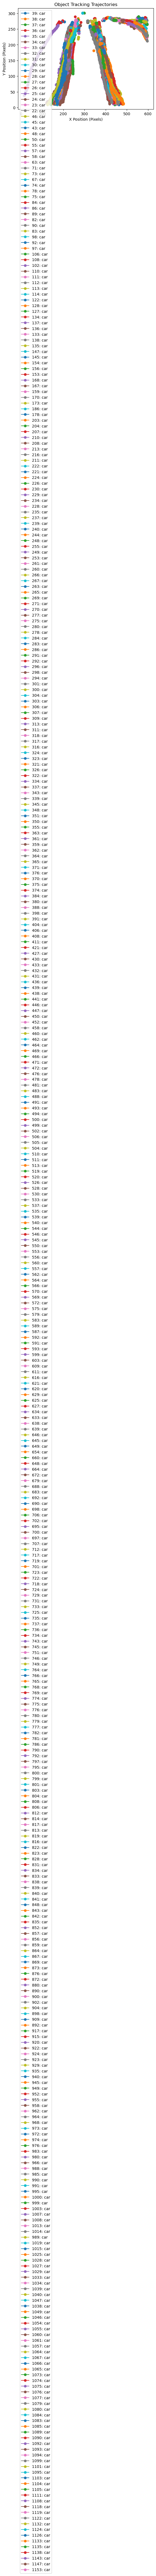

In [42]:
"""
The previous plot perfectly but it's mirror representation.
To make it similar to the video, we need to mirror the trajectory horizontally.
Therefore, we need to convert x into x', where x'=image_width - x
It will perfectly plot similar to input video plot
"""

# Create a plot
fig, ax = plt.subplots()
ax.set_title("Object Tracking Trajectories")
ax.set_xlabel("X Position (Pixels)")
ax.set_ylabel("Y Position (Pixels)")

# Get the frame width and height
image_width = 600   # Use the width of the processed video frames
image_height = 400 # Use the height of the processed video frames

# Plot the corrected trajectories
for trk_id, data in tracker_positions.items():
    x_vals = [image_width - pos[0] for pos in data['positions']]  # Flip X-coordinates
    y_vals = [image_height - pos[1] for pos in data['positions']] # Flip Y-coordinates
    
    obj_name = data['object']
    print(f"Total frame captured in ID: {trk_id}: {len(obj_name)}")

    ax.plot(x_vals, y_vals, marker='o', linestyle='-', label=f"{trk_id}: {obj_name[0]}")

ax.legend()
plt.show()
